In [1]:
import pandas as pd
df = pd.read_csv('train_test_network.csv', encoding='utf-8')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211043 entries, 0 to 211042
Data columns (total 44 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   src_ip                  211043 non-null  object 
 1   src_port                211043 non-null  int64  
 2   dst_ip                  211043 non-null  object 
 3   dst_port                211043 non-null  int64  
 4   proto                   211043 non-null  object 
 5   service                 211043 non-null  object 
 6   duration                211043 non-null  float64
 7   src_bytes               211043 non-null  int64  
 8   dst_bytes               211043 non-null  int64  
 9   conn_state              211043 non-null  object 
 10  missed_bytes            211043 non-null  int64  
 11  src_pkts                211043 non-null  int64  
 12  src_ip_bytes            211043 non-null  int64  
 13  dst_pkts                211043 non-null  int64  
 14  dst_ip_bytes        

In [2]:
# df.head()
# for col in df.select_dtypes(include='object').columns:
#     print(f"{col}: {df[col].nunique()} unique values")
df.dtypes

src_ip                     object
src_port                    int64
dst_ip                     object
dst_port                    int64
proto                      object
service                    object
duration                  float64
src_bytes                   int64
dst_bytes                   int64
conn_state                 object
missed_bytes                int64
src_pkts                    int64
src_ip_bytes                int64
dst_pkts                    int64
dst_ip_bytes                int64
dns_query                  object
dns_qclass                  int64
dns_qtype                   int64
dns_rcode                   int64
dns_AA                     object
dns_RD                     object
dns_RA                     object
dns_rejected               object
ssl_version                object
ssl_cipher                 object
ssl_resumed                object
ssl_established            object
ssl_subject                object
ssl_issuer                 object
http_trans_dep

In [3]:
import pandas as pd
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from scipy.stats import mode
import time
import os
from joblib import dump, load
import os
from scipy.stats import mode
from tqdm import tqdm
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
    

SEED = 42
NUM_FEATURES = 13

In [4]:
categorical_cols = df.select_dtypes(include='object').columns
label_encoders = {}

le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
    print(f"\nColumn: {col}")
    print(dict(zip(le.classes_, le.transform(le.classes_))))

feature_names = df.columns

X = df.drop('label', axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
print(f"Original class distribution: {np.bincount(y_train)}")

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


pca = PCA(n_components=NUM_FEATURES, random_state=SEED)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test_scaled)

print("Features Selected: ")
for i, component in enumerate(pca.components_):
    # Get the index of the feature with the largest absolute value in this component
    important_idx = np.argmax(np.abs(component))
    print(f"Principal Component {i+1}: most important feature is '{feature_names[important_idx]}'")


X_train = X_train_pca
X_test = X_test_pca

print(X_train.shape)
print(X_test.shape)



Column: src_ip
{'13.55.50.68': 0, '172.17.0.5': 1, '172.17.0.7': 2, '172.17.0.8': 3, '192.168.1.1': 4, '192.168.1.103': 5, '192.168.1.133': 6, '192.168.1.152': 7, '192.168.1.169': 8, '192.168.1.17': 9, '192.168.1.180': 10, '192.168.1.184': 11, '192.168.1.186': 12, '192.168.1.190': 13, '192.168.1.191': 14, '192.168.1.192': 15, '192.168.1.193': 16, '192.168.1.194': 17, '192.168.1.195': 18, '192.168.1.250': 19, '192.168.1.30': 20, '192.168.1.31': 21, '192.168.1.32': 22, '192.168.1.33': 23, '192.168.1.34': 24, '192.168.1.36': 25, '192.168.1.37': 26, '192.168.1.38': 27, '192.168.1.39': 28, '192.168.1.46': 29, '192.168.1.49': 30, '192.168.1.6': 31, '192.168.1.79': 32, '199.115.158.193': 33, '203.14.129.10': 34, '220.158.215.20': 35, '2405:6e00:10ce:2c00:20c:29ff:fed2:b002': 36, '2405:6e00:10ce:2c00:20c:29ff:feee:e07a': 37, '2405:6e00:10ce:2c00:8520:4eba:6770:702a': 38, '2405:6e00:10ce:2c00:9064:17:85d2:57d4': 39, '2405:6e00:10ce:2c00:c058:dbaa:f212:a2d8': 40, 'fe80::1087:c341:7263:ead3': 41

In [5]:
from joblib import dump, load

# dump(scaler, 'scaler.joblib')
# dump(pca, 'pca.joblib')
dump(label_encoders, 'label_encoders.joblib')
# dump(categorical_cols, 'categorical_cols.joblib')
# dump(feature_names, 'feature_names.joblib')

['label_encoders.joblib']

In [6]:
def create_sequential_batches(X_train, y_train, X_test, y_test, train_batch_size=300, test_batch_size=100):
    train_batches = []
    test_batches = []
    num_batches = min(len(X_train) // train_batch_size, len(X_test) // test_batch_size)
    for i in range(num_batches):
        train_start = i * train_batch_size
        train_end = train_start + train_batch_size
        test_start = i * test_batch_size
        test_end = test_start + test_batch_size
        train_batches.append((X_train[train_start:train_end], y_train[train_start:train_end]))
        test_batches.append((X_test[test_start:test_end], y_test[test_start:test_end]))
    return train_batches, test_batches

# Usage:
train_batches, test_batches = create_sequential_batches(X_train, y_train, X_test, y_test)

In [7]:
SEED = 42
# NUM_FEATURES = 4
TRAIN_BATCH_SIZE = 300
TEST_BATCH_SIZE = 100
NUM_BATCHES = 10

from joblib import Parallel, delayed


dev = qml.device("default.qubit", wires=NUM_FEATURES)

@qml.qnode(dev)
def kernel_circuit(x1, x2):
    qml.AngleEmbedding(x1, wires=range(NUM_FEATURES))
    qml.adjoint(qml.AngleEmbedding)(x2, wires=range(NUM_FEATURES))
    return qml.probs(wires=range(NUM_FEATURES))

def kernel(x1, x2):
    return kernel_circuit(x1, x2)

def compute_kernel_matrix(X1, X2):
    n_samples_1, n_samples_2 = len(X1), len(X2)
    kernel_matrix = np.zeros((n_samples_1, n_samples_2))
    for i in range(n_samples_1):
        for j in range(n_samples_2):
            probs = kernel_circuit(X1[i], X2[j])
            kernel_matrix[i, j] = probs[0]  # this represents the inner product now
    return kernel_matrix

In [8]:
from sklearn.model_selection import GridSearchCV

# Store metrics
all_test_preds = []
all_test_labels = []
train_accuracies = []
test_accuracies = []


for batch_idx in range(10):
    print(f"\nBatch {batch_idx + 1}/10")

    # Get batch data
    X_batch_train, y_batch_train = train_batches[batch_idx]
    X_batch_test, y_batch_test = test_batches[batch_idx]

    print("- Computing training kernel...")
    K_train = compute_kernel_matrix(X_batch_train, X_batch_train)

    print("- Computing testing kernel...")
    K_test = compute_kernel_matrix(X_batch_test, X_batch_train)

    if batch_idx == 4:
        K_train_4 = K_train
        K_test_4 = K_test

    # Hyperparameter tuning for C
    print("- Tuning C value...")
    param_grid = {"C": [0.1, 1, 10, 20, 30, 40, 50, 60]}
    grid = GridSearchCV(SVC(kernel='precomputed'), param_grid, cv=3)
    grid.fit(K_train, y_batch_train)
    best_model = grid.best_estimator_
    print(f"- Best C: {grid.best_params_['C']}")


    # Predictions
    y_pred = best_model.predict(K_test)
    all_test_preds.append(y_pred)
    all_test_labels.append(y_batch_test)

    # Overfitting check
    train_preds = best_model.predict(K_train)
    train_acc = accuracy_score(y_batch_train, train_preds)
    test_acc = accuracy_score(y_batch_test, y_pred)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"- Train Accuracy: {train_acc:.4f}")
    print(f"- Test Accuracy: {test_acc:.4f}")
    if train_acc - test_acc > 0.10:
        print("- Possible overfitting detected (Train >> Test)")



Batch 1/10
- Computing training kernel...
- Computing testing kernel...
- Tuning C value...
- Best C: 10
- Train Accuracy: 0.9967
- Test Accuracy: 0.9800

Batch 2/10
- Computing training kernel...
- Computing testing kernel...
- Tuning C value...
- Best C: 1
- Train Accuracy: 0.9900
- Test Accuracy: 0.9500

Batch 3/10
- Computing training kernel...
- Computing testing kernel...
- Tuning C value...
- Best C: 10
- Train Accuracy: 1.0000
- Test Accuracy: 0.9900

Batch 4/10
- Computing training kernel...
- Computing testing kernel...
- Tuning C value...
- Best C: 1
- Train Accuracy: 0.9933
- Test Accuracy: 0.9900

Batch 5/10
- Computing training kernel...
- Computing testing kernel...
- Tuning C value...
- Best C: 10
- Train Accuracy: 1.0000
- Test Accuracy: 0.9900

Batch 6/10
- Computing training kernel...
- Computing testing kernel...
- Tuning C value...
- Best C: 1
- Train Accuracy: 0.9933
- Test Accuracy: 0.9800

Batch 7/10
- Computing training kernel...
- Computing testing kernel...


Text(0.5, 1.0, 'Quantum Kernel Train Matrix')

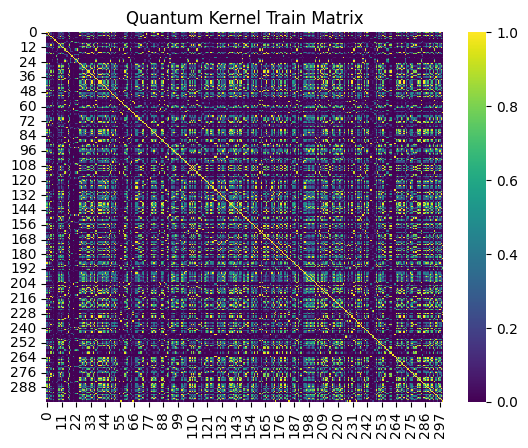

In [9]:
sns.heatmap(K_train_4, cmap="viridis")
plt.title("Quantum Kernel Train Matrix")

Text(0.5, 1.0, 'Quantum Kernel Test Matrix')

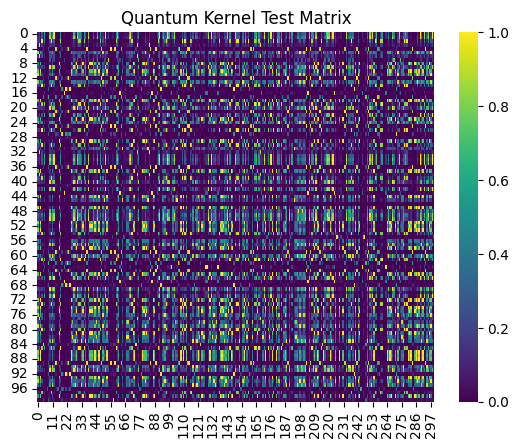

In [10]:
sns.heatmap(K_test_4, cmap="viridis")
plt.title("Quantum Kernel Test Matrix")


Final Batched QSVM Accuracy: 0.9720
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.91      0.94       252
           1       0.97      0.99      0.98       748

    accuracy                           0.97      1000
   macro avg       0.97      0.95      0.96      1000
weighted avg       0.97      0.97      0.97      1000



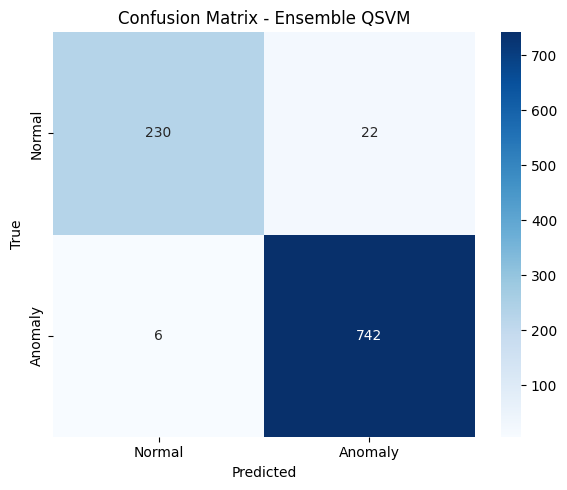

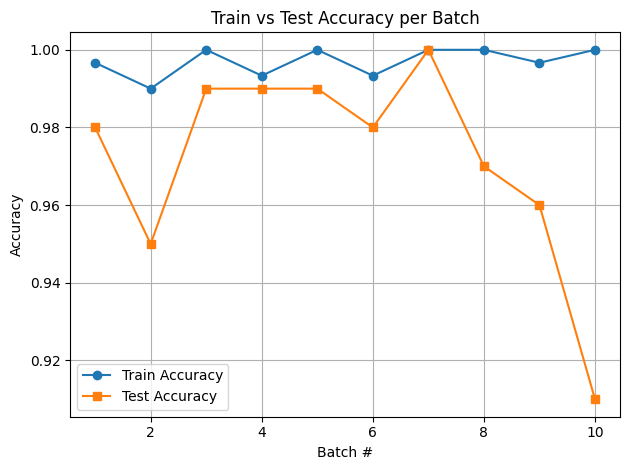

In [11]:
# Final evaluation
all_test_preds = np.concatenate(all_test_preds)
all_test_labels = np.concatenate(all_test_labels)

final_acc = accuracy_score(all_test_labels, all_test_preds)
print(f"\nFinal Batched QSVM Accuracy: {final_acc:.4f}")
print("Classification Report:\n", classification_report(all_test_labels, all_test_preds))

# Confusion matrix
cm = confusion_matrix(all_test_labels, all_test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.title("Confusion Matrix - Ensemble QSVM")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Plot train vs test accuracy
plt.plot(range(1, 11), train_accuracies, label="Train Accuracy", marker='o')
plt.plot(range(1, 11), test_accuracies, label="Test Accuracy", marker='s')
plt.title("Train vs Test Accuracy per Batch")
plt.xlabel("Batch #")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
import numpy as np

def compute_kta(kernel_matrix, labels):
    """
    Compute Kernel Target Alignment (KTA).
    :param kernel_matrix: (n x n) kernel matrix (usually training)
    :param labels: (n,) label vector
    :return: alignment score (float)
    """
    # Convert labels to +1 / -1
    y = np.where(labels == 1, 1, -1)
    target_matrix = np.outer(y, y)

    # Frobenius inner product
    numerator = np.sum(kernel_matrix * target_matrix)
    denominator = np.linalg.norm(kernel_matrix, 'fro') * np.linalg.norm(target_matrix, 'fro')

    return numerator / denominator


In [14]:
n_layers = 7


def qnn_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(NUM_FEATURES))
    qml.StronglyEntanglingLayers(weights, wires=range(NUM_FEATURES))
    return [qml.expval(qml.PauliZ(i)) for i in range(NUM_FEATURES)]

qnode = qml.QNode(qnn_circuit, dev, interface="torch")

class QNNClassifier(nn.Module):
    def __init__(self, n_layers, n_qubits):
        super().__init__()
        weight_shapes = {"weights": (n_layers, n_qubits, 3)}
        self.qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.fc = nn.Linear(n_qubits, 1)
    
    def forward(self, x):
        x = self.qlayer(x)
        x = self.fc(x)
        return x  # No sigmoid here

<generator object Module.parameters at 0x7f3731940f20>
Epoch 10/100, Loss: 0.1590
Epoch 20/100, Loss: 0.0898
Epoch 30/100, Loss: 0.0627
Epoch 40/100, Loss: 0.0488
Epoch 50/100, Loss: 0.0391
Epoch 60/100, Loss: 0.0319
Epoch 70/100, Loss: 0.0301
Epoch 80/100, Loss: 0.0247
Epoch 90/100, Loss: 0.0208
Epoch 100/100, Loss: 0.0205
QNN Accuracy on Test Data: 0.9920
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98       252
           1       0.99      1.00      0.99       748

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



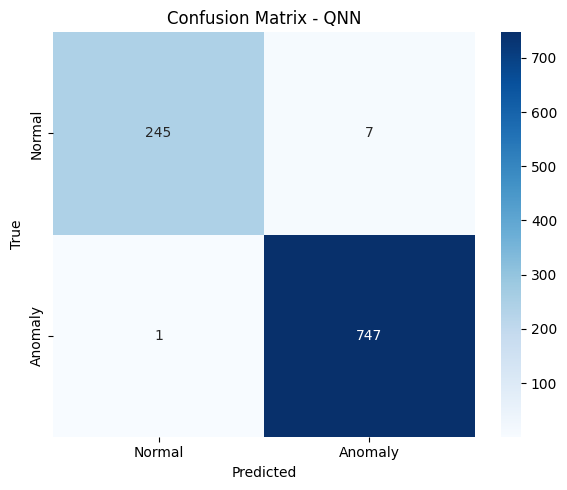

In [15]:
X_train_300 = X_train[:3000]
X_test_100 = X_test[:1000]
y_train_300 = y_train[:3000]
y_test_100 = y_test[:1000]

loss_values = []

# Prepare data
X_train_tensor = torch.tensor(X_train_300, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_300.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_100, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_100.values, dtype=torch.float32).unsqueeze(1)

# Use DataLoader for mini-batch training
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Model, loss, optimizer
model = QNNClassifier(n_layers=n_layers, n_qubits=NUM_FEATURES)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
print(model.parameters())

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    loss_values.append(epoch_loss)
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Evaluation
model.eval()
# with torch.no_grad():
#     y_pred_logits = model(X_test_tensor)
#     qnn_preds = (torch.sigmoid(y_pred_logits) > 0.5).int().squeeze().numpy()

with torch.no_grad():
    y_pred_logits = model(X_test_tensor)  # shape: (N, 1)
    qnn_sigmoid = torch.sigmoid(y_pred_logits).squeeze()  # shape: (N,)
    qnn_preds = (qnn_sigmoid > 0.5).int().numpy()

    # Convert to probability distribution over 2 classes: [P(class 0), P(class 1)]
    qnn_probs = torch.stack([1 - qnn_sigmoid, qnn_sigmoid], dim=1).cpu().numpy()  # shape: (N, 2)


accuracy_qnn = accuracy_score(y_test_100, qnn_preds)
print(f"QNN Accuracy on Test Data: {accuracy_qnn:.4f}")

print("Classification Report:\n", classification_report(y_test_100, qnn_preds))

cm = confusion_matrix(y_test_100, qnn_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.title("Confusion Matrix - QNN")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [16]:
from joblib import dump, load

dump(model, 'final_model(13  qnn).joblib')



['final_model(13  qnn).joblib']

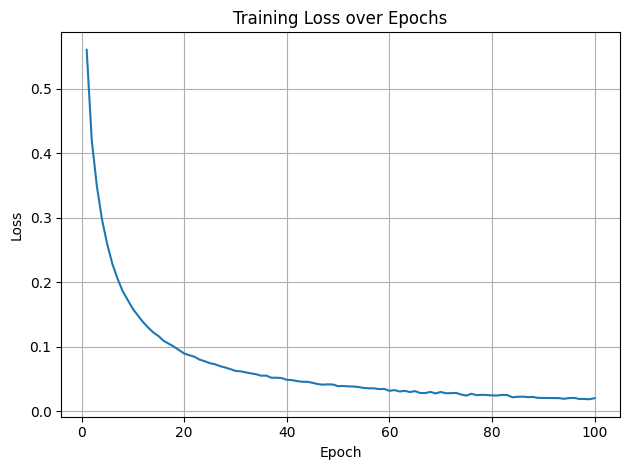

In [17]:
plt.plot(range(1, epochs + 1), loss_values, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.grid(True)
plt.tight_layout()
plt.show()

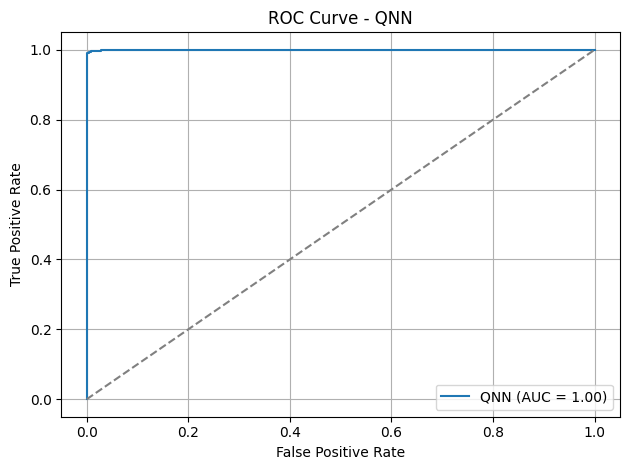

In [18]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test_100, qnn_sigmoid.numpy())
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'QNN (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - QNN")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
qnn_model = model

In [21]:
qsvm_preds = all_test_preds
X_meta = np.vstack([qsvm_preds, qnn_preds]).T  # shape: (n_samples, 2)
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the meta-model
meta_model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
meta_model_rf.fit(X_meta, y_test[:1000])  # match y_test slicing
ensemble_rf_preds = meta_model_rf.predict(X_meta)

print("Random Forest Meta-Model Accuracy:", accuracy_score(y_test[:1000], ensemble_rf_preds))
print("\nClassification Report (Random Forest Meta-Model):")
print(classification_report(y_test[:1000], ensemble_rf_preds))


Random Forest Meta-Model Accuracy: 0.992

Classification Report (Random Forest Meta-Model):
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       252
           1       0.99      1.00      0.99       748

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



In [22]:
from joblib import dump, load

dump(meta_model_rf, 'final_model(13).joblib')



['final_model(13).joblib']

In [23]:
model = load('final_model(13).joblib')
ensemble_rf_preds = model.predict(X_meta)
print("Random Forest Meta-Model Accuracy:", accuracy_score(y_test[:1000], ensemble_rf_preds))
print("\nClassification Report (Random Forest Meta-Model):")
print(classification_report(y_test[:1000], ensemble_rf_preds))

Random Forest Meta-Model Accuracy: 0.992

Classification Report (Random Forest Meta-Model):
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       252
           1       0.99      1.00      0.99       748

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



In [ ]:
full_model = {
    "qsvm": grid,                  
    "qnn": qnn_model,              
    "meta_model": meta_model_rf,      
    "label_encoders": label_encoders, 
    "scaler": scaler,                 
    "pca": pca,
    "feature_columns": list(feature_names)  
}

import joblib
joblib.dump(full_model, "quantum_meta_model.joblib")


Model saved as quantum_meta_model.joblib
